In [ ]:
!pip install opencv-python-headless
!pip install numpy

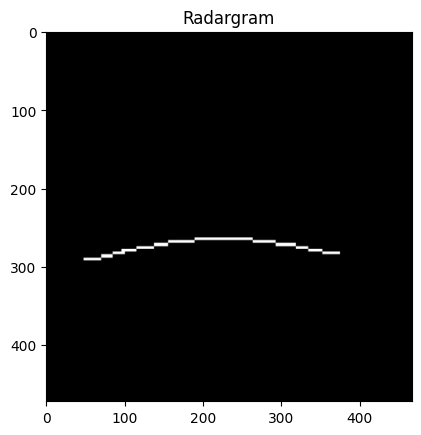

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/edge.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Radargram')
plt.show()


In [ ]:
print(image.shape)

(472, 467)


In [ ]:
def find_initial_pixel(image, part):
    height, width = image.shape
    column = (width // 3) * part
    if part == 2:
        column -= 1

    max_intensity = 0
    start_row = 0

    for row in range(height):
        if image[row, column] > max_intensity:
            max_intensity = image[row, column]
            start_row = row

    return (start_row, column)

In [ ]:
def search_apex(image, start_pixel):
    height, width = image.shape
    sum_of_moves = 0
    threshold = height // 10
    current_pixel = start_pixel

    while sum_of_moves <= threshold:
        row, col = current_pixel
        submatrix = image[max(0, row-1):min(height, row+2), col:col+2]
        local_max_pos = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        new_row, new_col = max(0, row-1) + local_max_pos[0], col + local_max_pos[1]

        if new_row == row or new_row > row:
            sum_of_moves += 1
        else:
            sum_of_moves = 0

        if new_col >= width - 1:
            break

        current_pixel = (new_row, new_col)

    return current_pixel

In [ ]:
def search_apex_right(image, start_pixel):
    height, width = image.shape
    sum_of_moves = 0
    threshold = height // 10
    current_pixel = start_pixel

    while sum_of_moves <= threshold:
        row, col = current_pixel
        submatrix = image[max(0, row-1):min(height, row+2), col:col+2]
        local_max_pos = np.unravel_index(np.argmax(submatrix[:, 1:]), submatrix[:, 1:].shape)
        local_max_pos = (local_max_pos[0], local_max_pos[1] + 1)
        new_row, new_col = max(0, row-1) + local_max_pos[0], col + local_max_pos[1]

        if new_row >= row:
            sum_of_moves += 1
        else:
            sum_of_moves = 0

        current_pixel = (new_row, new_col)

    return current_pixel


In [ ]:
def search_apex_left(image, start_pixel):
    height, width = image.shape
    sum_of_moves = 0
    threshold = height // 10
    current_pixel = start_pixel

    while sum_of_moves <= threshold:
        row, col = current_pixel
        submatrix = image[max(0, row-1):min(height, row+2), col-1:col+1]
        local_max_pos = np.unravel_index(np.argmax(submatrix[:, :-1]), submatrix[:, :-1].shape)
        new_row, new_col = max(0, row-1) + local_max_pos[0], col - 1 + local_max_pos[1]

        if new_row >= row:
            sum_of_moves += 1
        else:
            sum_of_moves = 0

        current_pixel = (new_row, new_col)

    return current_pixel


In [ ]:
def finalize_apex(pixels):
    pixels = np.array(pixels)
    apex_row = np.min(pixels[:, 0])
    apex_col_candidates = pixels[pixels[:, 0] == apex_row, 1]
    apex_col = np.mean(apex_col_candidates).astype(int)
    return (apex_row, apex_col)

# Find initial pixels for both parts
start_pixel_1 = find_initial_pixel(image, 1)
start_pixel_2 = find_initial_pixel(image, 2)

# Search apex in both directions
apex_right = search_apex_right(image, start_pixel_1)
apex_left = search_apex_left(image, start_pixel_2)

# Combine pixels from both searches and finalize apex
all_pixels = [apex_right, apex_left]
apex = finalize_apex(all_pixels)

print("Final Apex:", apex)

# Display the apex on the image
apex_image = image.copy()
apex_image[apex[0], apex[1]] = 255



Final Apex: (264, 226)


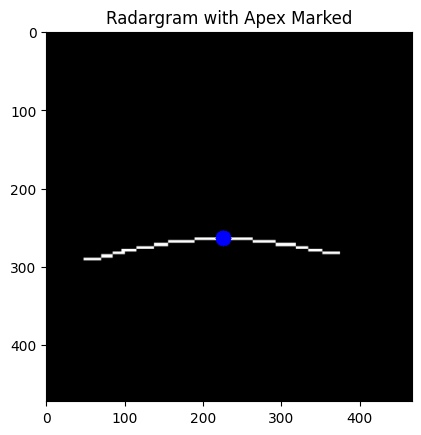

In [ ]:
def visualize_apex(image_path, apex):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Mark the apex on the image
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.circle(marked_image, (apex[1], apex[0]), 10, (0, 0, 255), -1)

    # Display the image
    plt.imshow(marked_image)
    plt.title('Radargram with Apex Marked')
    plt.show()

# Visualize the apex
visualize_apex(image_path, apex)

Prongs: [(264, 226), (264, 222), (264, 218), (264, 214), (264, 210), (264, 206), (264, 202), (264, 198), (264, 194), (264, 190), (267, 186), (267, 182), (267, 178), (267, 174), (267, 170), (267, 166), (267, 162), (267, 158), (267, 156), (270, 152), (271, 148), (271, 144), (271, 140), (271, 138), (274, 137), (275, 133), (275, 129), (275, 125), (275, 121), (275, 117), (275, 116), (278, 112), (278, 108), (278, 104), (278, 100), (278, 97), (281, 96), (282, 92), (282, 88), (282, 86), (285, 82), (285, 78), (285, 74), (285, 71), (285, 70), (285, 66), (285, 62), (285, 58), (285, 54), (285, 50), (285, 46), (285, 42), (285, 38), (285, 34), (285, 30), (285, 26), (285, 22), (285, 18), (285, 14), (285, 10), (285, 6), (285, 2)]


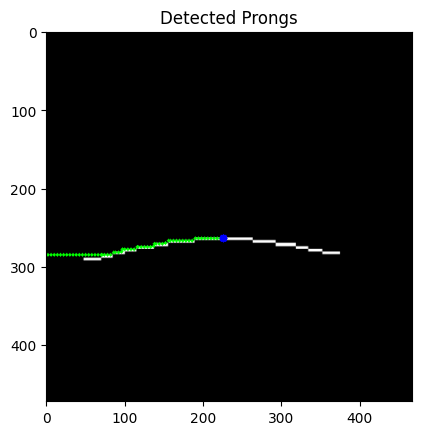

In [ ]:
def find_prongs(image, apex):
    height, width = image.shape
    prongs = [apex]
    current_pixel = apex

    # Search to the right of the apex
    while current_pixel[1] < width - 4:  # Make sure we stay within bounds for 4x4 submatrix
        row, col = current_pixel

        # Create the 4x4 submatrix
        submatrix = image[row:row+4, col:col+4]

        # Find the local maximum in the 4x4 matrix
        local_max_pos = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        new_row, new_col = row + local_max_pos[0], col + local_max_pos[1]

        if new_row == row and new_col == col:
            break

        prongs.append((new_row, new_col))
        current_pixel = (new_row, new_col)

    # Reset current_pixel to apex for searching to the left
    current_pixel = apex

    # Search to the left of the apex
    while current_pixel[1] > 3:  # Make sure we stay within bounds for 4x4 submatrix
        row, col = current_pixel

        # Create the 4x4 submatrix
        submatrix = image[row:row+4, col-4:col]

        # Find the local maximum in the 4x4 matrix
        local_max_pos = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        new_row, new_col = row + local_max_pos[0], col - 4 + local_max_pos[1]

        if new_row == row and new_col == col:
            break

        prongs.append((new_row, new_col))
        current_pixel = (new_row, new_col)

    return prongs

# Find prongs
prongs = find_prongs(image, apex)
print("Prongs:", prongs)

# Display prongs on the image
color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Enhance visibility for apex (red) and prongs (green)
for (row, col) in prongs:
    cv2.circle(color_image, (col, row), 2, (0, 255, 0), -1)  # Green circles for prongs

# Red circle for apex
cv2.circle(color_image, (apex[1], apex[0]), 5, (0, 0, 255), -1)  # Red circle for apex

plt.imshow(color_image)
plt.title('Detected Prongs')
plt.show()
